## Importing all dependencies for the Notebook


In [29]:
import os, sys
import findspark
from pathlib import Path
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, min as spark_min, max as spark_max,
    avg, length, to_timestamp, expr, to_date, sum as spark_sum
)
import time 
import pandas as pd 
import matplotlib.pyplot as plt 


## Initializing Java Home for Spark
- Notebook setup, change path to path of local JAVA HOME install


In [ ]:
print("Python executable:", sys.executable)
print("Python version   :", sys.version)
print("JAVA_HOME before :", os.environ.get("JAVA_HOME"))

JAVA_HOME = "/opt/homebrew/Cellar/openjdk@11/11.0.29/libexec/openjdk.jdk/Contents/Home"
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PATH"] = os.path.join(JAVA_HOME, "bin") + ":" + os.environ["PATH"]

print("JAVA_HOME after  :", os.environ.get("JAVA_HOME"))

import subprocess
print("\njava -version from this kernel:")
print(subprocess.check_output(["java", "-version"], stderr=subprocess.STDOUT).decode())

findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("test_jvm")
        .getOrCreate()
)

print("\nSpark version:", spark.version)

# Tiny test job
spark.range(5).show()


In [28]:
try:
    project_root = Path(
        subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
        .decode()
        .strip()
    )
except Exception:
    project_root = Path.cwd().parent

print("PROJECT ROOT:", project_root)

raw_dir = project_root / "data" / "raw"
print("RAW DATA DIR:", raw_dir)

spark = (
    SparkSession.builder
        .appName("IRA_Tweets_Task1")
        .master("local[*]")
        .config("spark.driver.memory", "6g")      # adjust down/up depending on your RAM
        .config("spark.executor.memory", "6g")    # local = same as driver
        .config("spark.sql.shuffle.partitions", "4")
        .getOrCreate()
)

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv(str(raw_dir))
)

df.printSchema()
print("Total rows:", df.count())

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")



PROJECT ROOT: /Users/sanduandrei/Desktop/BigData
RAW DATA DIR: /Users/sanduandrei/Desktop/BigData/data/raw


25/12/05 17:53:25 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/12/05 17:53:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndp

root
 |-- external_author_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- harvested_date: string (nullable = true)
 |-- following: integer (nullable = true)
 |-- followers: integer (nullable = true)
 |-- updates: integer (nullable = true)
 |-- post_type: string (nullable = true)
 |-- account_type: string (nullable = true)
 |-- retweet: integer (nullable = true)
 |-- account_category: string (nullable = true)
 |-- new_june_2018: integer (nullable = true)
 |-- alt_external_id: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- article_url: string (nullable = true)
 |-- tco1_step1: string (nullable = true)
 |-- tco2_step1: string (nullable = true)
 |-- tco3_step1: string (nullable = true)



Total rows: 2946207


25/12/05 17:53:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

## Exploratory analysis 
- Exploring the dataset by looking for:
    - Total number of tweets
    - Total number of unique accounts
    - Average tweets per account
    - Media tweets per account
    - Max tweets by a single amount
    - Std dev of tweets per account
    - Mean account lifespan (days)
    - Average tweet length (characters)
    - Average followers per account 

In [ ]:
# timestamp column
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")
)

# global accounts
total_tweets = df.count()
n_accounts = df.selectExpr("count(distinct author) as n").first()["n"]

# / account stats
acct_stats_spark = (
    df_time.groupBy("author")
           .agg(
               count("*").alias("n_tweets"),
               spark_min("publish_ts").alias("first_ts"),
               spark_max("publish_ts").alias("last_ts"),
               avg("followers").alias("avg_followers")
           )
)

acct_stats = acct_stats_spark.toPandas()

# lifespan
acct_stats["lifespan_days"] = (
    (acct_stats["last_ts"] - acct_stats["first_ts"])
    .dt.total_seconds() / 86400.0
).clip(lower=0)

# acc level metrics
avg_tweets = acct_stats["n_tweets"].mean()
median_tweets = acct_stats["n_tweets"].median()
max_tweets = acct_stats["n_tweets"].max()
std_tweets = acct_stats["n_tweets"].std()

mean_lifespan = acct_stats["lifespan_days"].mean()
avg_followers_per_account = acct_stats["avg_followers"].mean()

# avg tweet length 
avg_tweet_length = (
    df.select(avg(length("content")).alias("avg_len"))
      .first()["avg_len"]
)

# defining stats table 
stats_df = pd.DataFrame({
    "Metric": [
        "Total number of tweets",
        "Total number of unique accounts",
        "Average tweets per account",
        "Median tweets per account",
        "Max tweets by a single account",
        "Std dev of tweets per account",
        "Mean account lifespan (days)",
        "Average tweet length (characters)",
        "Average followers per account",
    ],
    "Value": [
        f"{total_tweets:,}",
        f"{n_accounts:,}",
        f"{avg_tweets:.2f}",
        f"{median_tweets:.2f}",
        f"{max_tweets:,}",
        f"{std_tweets:.2f}",
        f"{mean_lifespan:.2f}",
        f"{avg_tweet_length:.2f}",
        f"{avg_followers_per_account:.2f}",
    ]
})

plt.close('all')

# plt 
fig, ax = plt.subplots(figsize=(9, 3))
ax.axis("off")

# Add the title ABOVE the table
fig, ax = plt.subplots(figsize=(9, 3))

# Move the table lower so the title fits
ax.set_position([0, -0.05, 1, 1])
ax.axis("off")

plt.title("Key Dataset Statistics", pad=20)

table = ax.table(
    cellText=stats_df.values,
    colLabels=stats_df.columns,
    loc="center",
    cellLoc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

plt.show()

## Tweet distribution statistics
- Detecting spread of nunique tweets

In [ ]:
tweets_per_account_spark = (
    df.groupBy("author")
      .count()
      .withColumnRenamed("count", "tweets_per_account")
)

tweets_per_account = tweets_per_account_spark.toPandas()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Tweets per Account (Linear Scale)")
plt.xlabel("Number of Tweets")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(tweets_per_account["tweets_per_account"], bins=50, color="salmon", edgecolor="black", log=True)
plt.title("Distribution of Tweets per Account (Log Scale)")
plt.xlabel("Number of Tweets (log scale)")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

## Detecting outliers 
- We create new smaller datasets derived from the initial dataset of accounts that are outliers 
- This is done to explore the most prominent trolls and investigate their behaviour 

In [ ]:
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

# high activity datasets
accounts_over_50000 = tweets_per_account.filter(col("tweets_per_account") > 50000)
accounts_over_40000 = tweets_per_account.filter(col("tweets_per_account") > 40000)


print("Accounts with > 50,000 tweets:")
accounts_over_50000.show(truncate=False)

print("\nAccounts with > 40,000 tweets:")
accounts_over_40000.show(truncate=False)

# convertion to pandas for inspection
accounts_50k_pd = accounts_over_50000.toPandas()
accounts_40k_pd = accounts_over_40000.toPandas()

accounts_50k_pd, accounts_40k_pd

# tweets per account
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

# pandas for percentile calc
tp_pd = tweets_per_account.toPandas()

# # 95th percentile 
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)

print(f"90th percentile tweet count threshold: {p95_threshold:.2f}")

# nunique accounts above 95th percentile
n_above_90 = (tp_pd["tweets_per_account"] > p95_threshold).sum()

print(f"Number of accounts above 95th percentile: {n_above_90}")

# show as df
accounts_above_90 = tweets_per_account.filter(col("tweets_per_account") > p95_threshold)
accounts_above_90.show(truncate=False)


## Further exploration of the outliers 

In [ ]:
tweets_per_account = (
    df.groupBy("author")
      .agg(count("*").alias("tweets_per_account"))
)

tp_pd = tweets_per_account.toPandas()
p95_threshold = tp_pd["tweets_per_account"].quantile(0.95)

p95_threshold

accounts_above_95 = (
    tweets_per_account
        .filter(col("tweets_per_account") > p95_threshold)
        .withColumnRenamed("author", "account")
)

accounts_above_95.show(truncate=False)
print("Number of accounts above 95th percentile:", accounts_above_95.count())

df_top5 = (
    df.join(accounts_above_95, df.author == accounts_above_95.account, "inner")
      .drop(accounts_above_95.account)
)

df_top5.printSchema()
print("Total tweets from top 5% accounts:", df_top5.count())


## Tweets by account category over time 

25/12/05 17:57:55 ERROR Inbox: Ignoring error================>    (11 + 1) / 12]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apach

+----+-----+----------------+-----+
|year|month|account_category|count|
+----+-----+----------------+-----+
|2015|7    |RightTroll      |24795|
|2016|7    |RightTroll      |6001 |
|2016|8    |RightTroll      |6261 |
|2016|9    |RightTroll      |39053|
|2015|9    |RightTroll      |4479 |
|2015|11   |RightTroll      |9828 |
|2017|1    |HashtagGamer    |15663|
|2016|11   |HashtagGamer    |20231|
|2014|12   |HashtagGamer    |3137 |
|2016|2    |HashtagGamer    |4153 |
+----+-----+----------------+-----+
only showing top 10 rows



+----------------+------------+
|account_category|total_tweets|
+----------------+------------+
|NonEnglish      |820722      |
|RightTroll      |711625      |
|NewsFeed        |598155      |
|LeftTroll       |427056      |
|HashtagGamer    |241786      |
|Commercial      |121904      |
|Unknown         |13534       |
|Fearmonger      |11140       |
+----------------+------------+



Top categories to plot: ['NonEnglish', 'RightTroll', 'NewsFeed', 'LeftTroll', 'HashtagGamer']


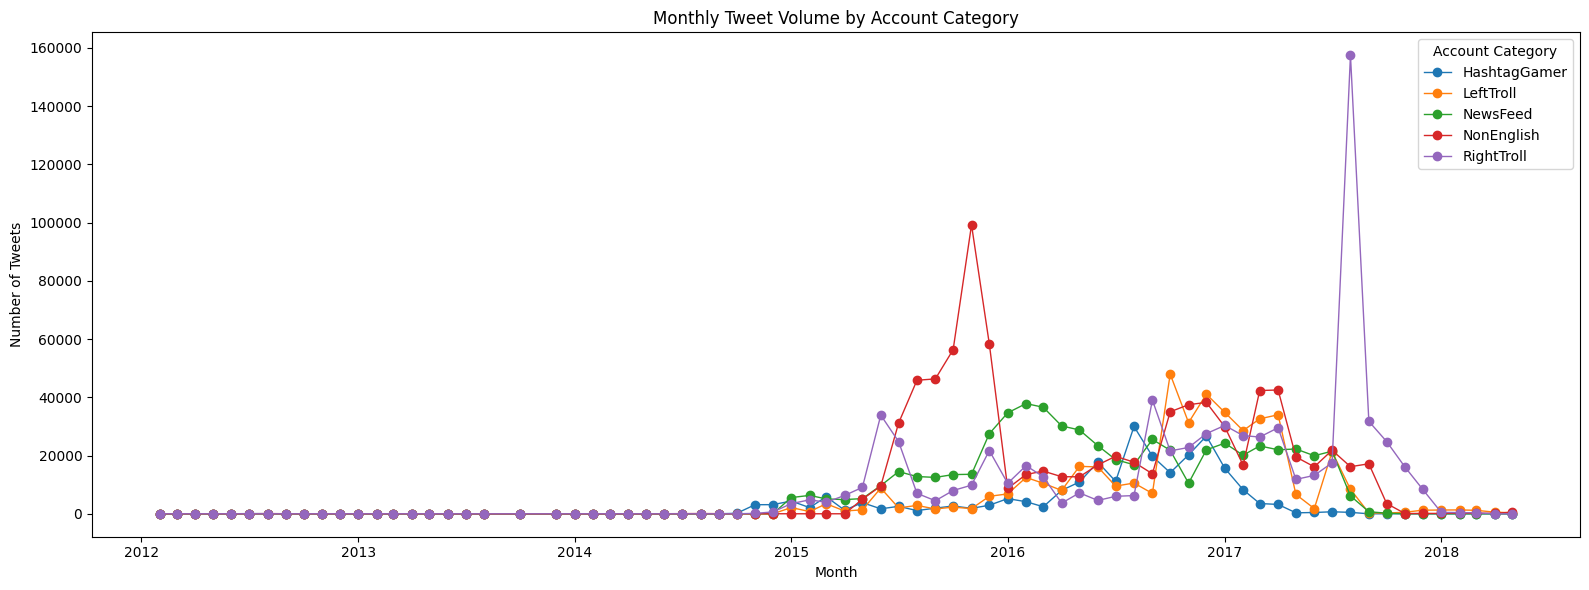

25/12/05 17:58:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_time = df.withColumn(
    "publish_ts",
    to_timestamp("publish_date", "M/d/yyyy H:mm")  # handles 1/2/2017 14:39 etc.
)

# tweets per month by account category 
df_cat_monthly = (
    df_time
        .where(col("publish_ts").isNotNull())
        .groupBy(
            year("publish_ts").alias("year"),
            month("publish_ts").alias("month"),
            col("account_category")
        )
        .count()
)

df_cat_monthly.show(10, truncate=False)

# top n categories by tweet volume 
cat_totals = (
    df_cat_monthly
        .groupBy("account_category")
        .agg(spark_sum("count").alias("total_tweets"))
        .orderBy(col("total_tweets").desc())
)

cat_totals.show(truncate=False)

# choose top 4–5 categories for a clean plot
TOP_N = 5
top_categories = [
    row["account_category"]
    for row in cat_totals.limit(TOP_N).collect()
    if row["account_category"] is not None
]

print("Top categories to plot:", top_categories)

# monthly data convert to pandas 
cat_monthly_pd = df_cat_monthly.toPandas()

# filter to top categories only
cat_monthly_pd = cat_monthly_pd[cat_monthly_pd["account_category"].isin(top_categories)]

# build a proper year_month datetime for x-axis
cat_monthly_pd["year_month"] = pd.to_datetime(
    cat_monthly_pd["year"].astype(str) + "-" +
    cat_monthly_pd["month"].astype(str).str.zfill(2) + "-01"
)

# pivot: rows = year_month, columns = account_category, values = tweet counts
pivot = cat_monthly_pd.pivot_table(
    index="year_month",
    columns="account_category",
    values="count",
    aggfunc="sum",
    fill_value=0
).sort_index()

pivot.head()

# Tweets over time by account_category

plt.figure(figsize=(16, 6))

for category in pivot.columns:
    plt.plot(pivot.index, pivot[category], marker="o", linewidth=1, label=category)

plt.title("Monthly Tweet Volume by Account Category")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.legend(title="Account Category")
plt.tight_layout()
plt.show()